In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import util
from util import Camera
from util_gau import load_ply, naive_gaussian, GaussianData


In [165]:
gaussians = naive_gaussian()
g_width, g_height = 1280, 720
scale_modifier = 1.0

SH_C0 = 0.28209479177387814
SH_C1 = 0.4886025119029199
SH_C2_0 = 1.0925484305920792
SH_C2_1 = -1.0925484305920792
SH_C2_2 = 0.31539156525252005
SH_C2_3 = -1.0925484305920792
SH_C2_4 = 0.5462742152960396
SH_C3_0 = -0.5900435899266435
SH_C3_1 = 2.890611442640554
SH_C3_2 = -0.4570457994644658
SH_C3_3 = 0.3731763325901154
SH_C3_4 = -0.4570457994644658
SH_C3_5 = 1.445305721320277
SH_C3_6 = -0.5900435899266435

class Gaussian:
    def __init__(self, pos, scale, rot, opacity, sh):
        self.pos = np.array(pos)
        self.scale = np.array(scale_modifier * scale)
        # Initialize scipy Quaternion from rot (s, x, y, z)
        self.rot = sp.spatial.transform.Rotation.from_quat([rot[1], rot[2], rot[3], rot[0]])
        self.opacity = opacity[0]
        self.sh = np.array(sh)
        self.cov3D = self.compute_cov3d()

    def compute_cov3d(self):
        cov3D = np.diag(self.scale**2)
        cov3D = self.rot.as_matrix().T @ cov3D @ self.rot.as_matrix()
        return cov3D

    def get_cov2d(self, camera):
        view_mat = camera.get_view_matrix()
        g_pos_w = np.append(self.pos, 1.0)
        # g_pos_cam = camera.world_to_cam(self.pos)
        g_pos_cam = view_mat @ g_pos_w
        view_matrix = camera.get_view_matrix()
        [htan_fovx, htan_fovy, focal] = camera.get_htanfovxy_focal()
        focal_x = focal_y = focal

        t = np.copy(g_pos_cam)

        limx = 1.3 * htan_fovx
        limy = 1.3 * htan_fovy
        txtz = t[0]/t[2]
        tytz = t[1]/t[2]

        tx = min(limx, max(-limx, txtz)) * t[2]
        ty = min(limy, max(-limy, tytz)) * t[2]
        tz = t[2]

        J = np.array([
            [focal_x/tz, 0.0, -(focal_x * tx)/(tz * tz)],
            [0.0, focal_y/tz, -(focal_y * ty)/(tz * tz)],
            [0.0, 0.0, 0.0]
        ])
        W = view_matrix[:3, :3].T
        T = W @ J
        cov = T.T @ self.cov3D.T @ T

        cov[0,0] += 0.3
        cov[1,1] += 0.3
        return cov[:2, :2]

    def get_depth(self, camera):
        view_matrix = camera.get_view_matrix()
        
        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        depth = g_pos_view[2]
        return depth

    def get_conic_and_bb(self, camera):
        cov2d = self.get_cov2d(camera)

        det = np.linalg.det(cov2d)
        if det == 0.0:
            return None
        
        det_inv = 1.0 / det
        cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]]
        conic = np.array([cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv])
        # cov_inv= np.linalg.inv(cov2d)
        # conic = np.array([cov_inv[0,0], cov_inv[0,1], cov_inv[1,1]])
        # compute 3-sigma bounding box size
        bboxsize_cam = np.array([3.0 * np.sqrt(cov2d[0,0]), 3.0 * np.sqrt(cov2d[1,1])])
        # bboxsize_cam = np.array([3.0 * np.sqrt(cov[0]), 3.0 * np.sqrt(cov[2])])        
        # Divide out camera plane size to get bounding box size in NDC
        wh = np.array([camera.w, camera.h])
        bboxsize_ndc = np.divide(bboxsize_cam, wh) * 2

        vertices = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]])
        # Four coordxy values (used to evaluate gaussian, also in camera space coordinates)
        bboxsize_cam = np.multiply(vertices, bboxsize_cam)

        # compute g_pos_screen and gl_position
        view_matrix = camera.get_view_matrix()
        projection_matrix = camera.get_projection_matrix()

        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        g_pos_screen = projection_matrix @ g_pos_view
        g_pos_screen = g_pos_screen / g_pos_screen[3]
        
        bbox_ndc = np.multiply(vertices, bboxsize_ndc) + g_pos_screen[:2]
        bbox_ndc = np.hstack((bbox_ndc, np.zeros((vertices.shape[0],2))))
        bbox_ndc[:,2:4] = g_pos_screen[2:4]

        return conic, bboxsize_cam, bbox_ndc

    def get_color(self, dir) -> np.ndarray:
        """Samples spherical harmonics to get color for given view direction"""
        c0 = self.sh[0:3]   # f_dc_* from the ply file)
        color = SH_C0 * c0

        shdim = len(self.sh)

        if shdim > 3:
            # Add the first order spherical harmonics
            c1 = self.sh[3:6]
            c2 = self.sh[6:9]
            c3 = self.sh[9:12]
    
            x = dir[0]
            y = dir[1]
            z = dir[2]
            color = color - SH_C1 * y * c1 + SH_C1 * z * c2 - SH_C1 * x * c3
            
        if shdim > 12:
            c4 = self.sh[12:15]
            c5 = self.sh[15:18]
            c6 = self.sh[18:21]
            c7 = self.sh[21:24]
            c8 = self.sh[24:27]
    
            (xx, yy, zz) = (x * x, y * y, z * z)
            (xy, yz, xz) = (x * y, y * z, x * z)
            
            color = color +	SH_C2_0 * xy * c4 + \
                SH_C2_1 * yz * c5 + \
                SH_C2_2 * (2.0 * zz - xx - yy) * c6 + \
                SH_C2_3 * xz * c7 + \
                SH_C2_4 * (xx - yy) * c8

        if shdim > 27:
            c9 = self.sh[27:30]
            c10 = self.sh[30:33]
            c11 = self.sh[33:36]
            c12 = self.sh[36:39]
            c13 = self.sh[39:42]
            c14 = self.sh[42:45]
            c15 = self.sh[45:48]
    
            color = color + \
                SH_C3_0 * y * (3.0 * xx - yy) * c9 + \
                SH_C3_1 * xy * z * c10 + \
                SH_C3_2 * y * (4.0 * zz - xx - yy) * c11 + \
                SH_C3_3 * z * (2.0 * zz - 3.0 * xx - 3.0 * yy) * c12 + \
                SH_C3_4 * x * (4.0 * zz - xx - yy) * c13 + \
                SH_C3_5 * z * (xx - yy) * c14 + \
                SH_C3_6 * x * (xx - 3.0 * yy) * c15
        
        color += 0.5
        return np.clip(color, 0.0, 1.0)


# Iterate over the gaussians and create Gaussian objects
gaussian_objects = []
for (pos, scale, rot, opacity, sh) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity, gaussians.sh):
    gau = Gaussian(pos, scale, rot, opacity, sh)
    gaussian_objects.append(gau)

conic =  [0.07541478 0.         0.07541478] color r
conic =  [0.00173521 0.         0.07541478] color g
conic =  [0.07541478 0.         0.00173521] color b
conic =  [0.03394433 0.         0.03394433] color y


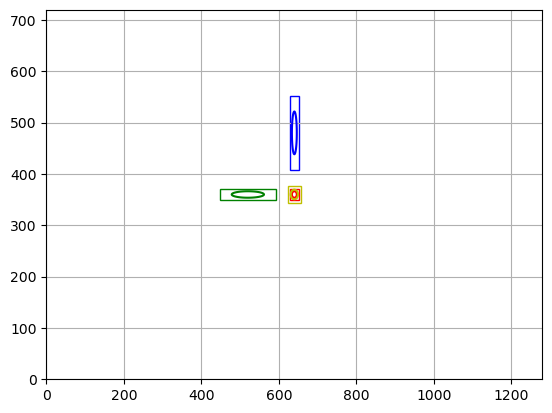

In [166]:
# Plot conic using equation A*x**2 + B*x*y + C*y**2 = 1
# where A, B, C are the conic parameters

# plot the boundary where the equation is satisfied

def plot_conics_and_bbs(gaussian_objects, camera):

    ax = plt.gca()
    colors = ['r', 'g', 'b', 'y', 'm', 'c']

    for g, color in zip(gaussian_objects, colors):
        (conic, bboxsize_cam, bbox_ndc) = g.get_conic_and_bb(camera)
        if conic is None:
            continue

        A, B, C = conic
        # coordxy is the correct scale to be used with gaussian and is already
        # centered on the gaussian
        coordxy = bboxsize_cam
        x_cam = np.linspace(coordxy[0][0], coordxy[1][0], 100)
        y_cam = np.linspace(coordxy[1][1], coordxy[2][1], 100)
        X, Y = np.meshgrid(x_cam, y_cam)
        
        # 1-sigma ellipse
        F = A*X**2 + 2*B*X*Y + C*Y**2 - 3.00

        bbox_screen = camera.ndc_to_pixel(bbox_ndc)

        # Use bbox offset to position of gaussian in screen coords to position the ellipse
        x_px = np.linspace(bbox_screen[0][0], bbox_screen[1][0], 100)
        y_px = np.linspace(bbox_screen[2][1], bbox_screen[1][1], 100)
        X_px, Y_px = np.meshgrid(x_px, y_px)
        F_val = 0.0
        plt.contour(X_px, Y_px, F, [F_val], colors=color)

        # Plot a rectangle around the gaussian position based on bb
        ul = bbox_screen[0,:2]
        ur = bbox_screen[1,:2]
        lr = bbox_screen[2,:2]
        ll = bbox_screen[3,:2]
        ax.add_patch(plt.Rectangle((ul[0], ul[1]), ur[0] - ul[0], lr[1] - ur[1], fill=False, color=color))

fig = plt.figure()
ax = plt.gca()
plot_conics_and_bbs(gaussian_objects, camera)
plt.xlim([0, camera.w])
plt.ylim([0, camera.h])
plt.grid(True)
plt.show()

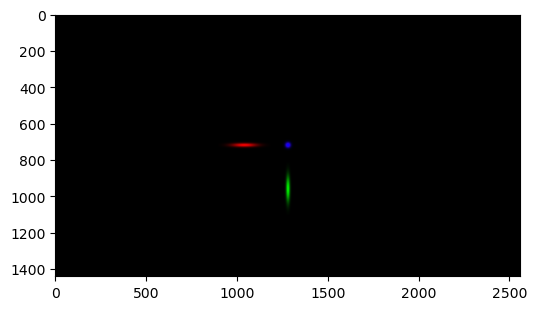

In [178]:
def plot_opacity(gaussian: Gaussian, camera: Camera, w: int, h: int, bitmap: np.ndarray, alphas: np.ndarray):
    # Compute the opacity of a gaussian given the camera
    conic, bboxsize_cam, bbox_ndc = gaussian.get_conic_and_bb(camera)

    A, B, C = conic

    screen_height, screen_width = bitmap.shape[:2]
    bbox_screen = camera.ndc_to_pixel(bbox_ndc, screen_width, screen_height)
    
    if np.any(np.isnan(bbox_screen)):
        return

    ul = bbox_screen[0,:2]
    ur = bbox_screen[1,:2]
    lr = bbox_screen[2,:2]
    ll = bbox_screen[3,:2]
    
    y1 = int(np.floor(ul[1]))
    y2 = int(np.ceil(ll[1]))
    
    x1 = int(np.floor(ul[0]))
    x2 = int(np.ceil(ur[0]))
    nx = x2 - x1
    ny = y2 - y1

    # Extract out inputs for the gaussian
    coordxy = bboxsize_cam
    x_cam_1 = coordxy[0][0]   # ul
    x_cam_2 = coordxy[1][0]   # ur
    y_cam_1 = coordxy[1][1]   # ur (y)
    y_cam_2 = coordxy[2][1]   # lr

    camera_dir = gaussian.pos - camera.position
    camera_dir = camera_dir / np.linalg.norm(camera_dir)
    color = gaussian.get_color(camera_dir)

    for x, x_cam in zip(range(x1, x2), np.linspace(x_cam_1, x_cam_2, nx)):
        if x < 0 or x >= w:
            continue
        for y, y_cam in zip(range(y1, y2), np.linspace(y_cam_1, y_cam_2, ny)):
            if y < 0 or y >= h:
                continue

            # Gaussian is typically calculated as f(x, y) = A * exp(-(a*x^2 + 2*b*x*y + c*y^2))
            power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
            if power > 0.0:
                continue

            alpha = gaussian.opacity * np.exp(power)
            alpha = min(0.99, alpha)
            if opacity < 1.0 / 255.0:
                continue

            # Set the pixel color to the given color and opacity
            # Do alpha blending using "over" method
            old_alpha = alphas[y, x]
            new_alpha = alpha + old_alpha * (1.0 - alpha)
            alphas[y, x] = new_alpha
            bitmap[y, x, :] = (color[0:3]) * alpha + bitmap[y, x, :] * (1.0 - alpha)

# Iterate over the gaussians and create Gaussian objects
gaussian_objects = []
for (pos, scale, rot, opacity, sh) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity, gaussians.sh):
    gau = Gaussian(pos, scale, rot, opacity, sh)
    gaussian_objects.append(gau)

camera = util.Camera(g_height, g_width)
# Get gaussian indices sorted by depth
indices = np.argsort([g.get_depth(camera) for g in gaussian_objects])

# Initialize a bitmap with alpha channel of size w x h
(h, w) = (1440, 2560)
bitmap = np.zeros((h, w, 3), np.float32)
alphas = np.zeros((h, w), np.float32)

plt.figure(figsize=(6,6))
for idx in indices:
    plot_opacity(gaussian_objects[idx], camera, w, h, bitmap, alphas)

# Plot the bitmap
plt.imshow(bitmap, vmin=0, vmax=1.0)

plt.show()

In [174]:
def plot_model(camera, gaussian_objects):
    print('Sorting the gaussians by depth')
    indices = np.argsort([gau.get_depth(camera) for gau in gaussian_objects])
    
    print('Plotting with', len(gaussian_objects), 'gaussians')
    bitmap = np.zeros((h, w, 3), np.float32)
    alphas = np.zeros((h, w), np.float32)
    
    for idx in tqdm(indices):
        plot_opacity(gaussian_objects[idx], camera, w, h, bitmap, alphas)
    
    return bitmap


In [180]:
model = load_ply('point_cloud.ply')
from tqdm import tqdm

print('Loading gaussians ...')
gaussian_objects = []
for (pos, scale, rot, opacity, sh) in tqdm(zip(model.xyz, model.scale, model.rot, model.opacity, model.sh)):
    gaussian_objects.append(Gaussian(pos, scale, rot, opacity, sh))

Loading gaussians ...


281498it [00:02, 97411.50it/s] 


Sorting the gaussians by depth
Plotting with 281498 gaussians


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 281498/281498 [04:02<00:00, 1159.41it/s]


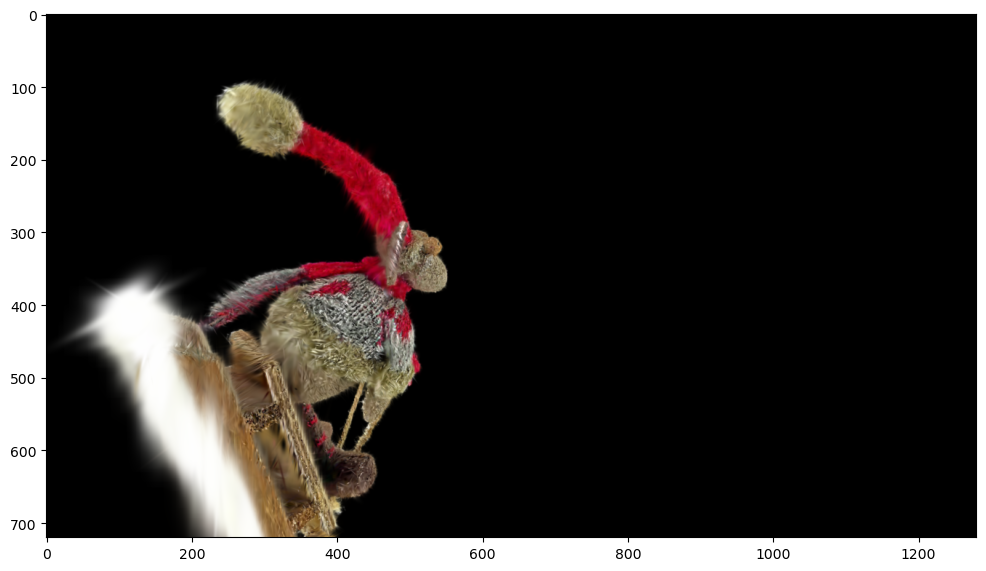

In [182]:
(h, w) = (720, 1280)
# camera = Camera(h, w, position=(0.94, 1.29, -2.65), target=(0.0, 0.66, 0.07))
camera = Camera(h, w, position=(-0.57651054, 2.99040512, -0.03924271), target=(-0.0, 0.0, 0.0))

bitmap = plot_model(camera, gaussian_objects)

plt.figure(figsize=(12, 12))
plt.imshow(bitmap, vmin=0, vmax=1.0)
plt.show()

In [188]:
print(gaussian_objects[0].rot.as_quat())

[0.07147696 0.65608435 0.63913785 0.39490148]
